# Grassmann Differential Evolution - An Experiment

What if we represent a point in DE using subspaces instead of vectors? Let's try!

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda


I want to solve PCA as the objective function, that is:

$$
    f(\textbf{X}) = \max_{\textbf{Q}} \text{tr}(\textbf{Q}^T\textbf{X}\textbf{Q})
$$
s.t
$$
    \textbf{Q} \in \text{Gr}(k, n)
$$

and

$\textbf{X}$ is an auto correlation matrix

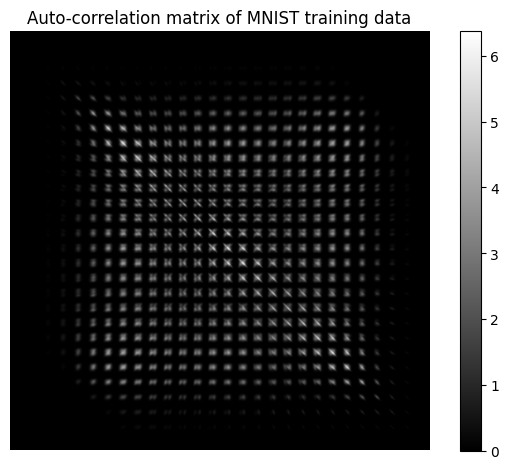

In [2]:
import torch
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt


def objective_function(X: torch.Tensor, Q: torch.Tensor) -> torch.Tensor:
    """Objective function to minimize."""
    return torch.einsum("...ii", Q.mH @ X @ Q) / Q.shape[-1]

def auto_correlation_matrix(data: torch.Tensor) -> torch.Tensor:
    _, n = data.shape
    data = (data - data.min()) / (data.max() - data.min())
    X = torch.matmul(data.mH, data)
    X /= (n - 1)
    return X

def show_matrix(X: torch.Tensor | list[torch.Tensor], title: str) -> None:
    if isinstance(X, torch.Tensor):
        assert X.dim() == 2
        plt.imshow(X.cpu().numpy(), cmap="gray")
        plt.colorbar()
        plt.title(title)
        plt.axis("off")
        plt.tight_layout()
        plt.show()
    elif isinstance(X, list):
        n = len(X)
        fig, axes = plt.subplots(1, n, figsize=(n * 2, 2))
        for i in range(n):
            axes[i].imshow(X[i].cpu().numpy(), cmap="gray")
            axes[i].axis("off")
        plt.title(title)
        plt.tight_layout()
        plt.show()

mnist = MNIST("~/Datasets", download=True, train=False)
data = mnist.data.view(mnist.data.shape[0], -1).float().to(device)

X = auto_correlation_matrix(data)
n_components = 5

show_matrix(X, "Auto-correlation matrix of MNIST training data")

### First let's compute PCA using an eigen-decomposition

In [3]:
eigenvalues, eigenvectors = torch.linalg.eig(X)

#  Eigenvalues are supposed to be positive reals.
# This condtion may fail only if there are numerical errors.
# We can ignore the torch warning here about casting complex -> real
if torch.max(torch.imag(eigenvalues)) > 1.e-5:
    raise (AssertionError(
        "Eigenvalues of autocorrelation matrix are supposed to be real, "
        f"but has imaginary part {torch.max(torch.imag(eigenvalues))}"))

eigenvalues = torch.real(eigenvalues)
eigenvectors = torch.real(eigenvectors)

squared_eigenvalues = torch.square(eigenvalues)
sorted_indices = torch.argsort(squared_eigenvalues, descending=True)
squared_eigenvalues.sort(descending=True)

Q1 = eigenvectors[:, sorted_indices][:, :n_components]

Objective function value: 138.437607


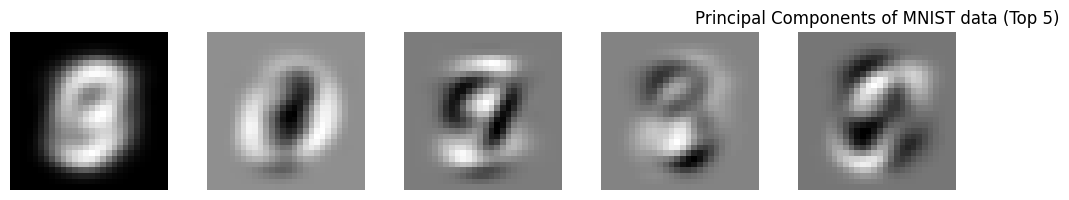

In [4]:
o = objective_function(X, Q1)
print(f"Objective function value: {o.item():.6f}")

show_matrix(
    [Q1[:, i].view(28, 28) for i in range(n_components)],
    f"Principal Components of MNIST data (Top {n_components})",
)

### Now let's try calculating PCA using differential evolution

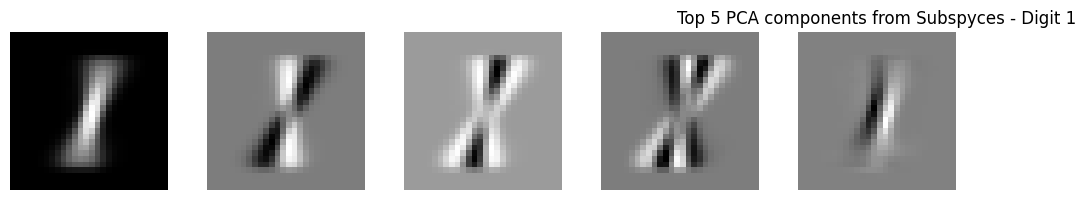

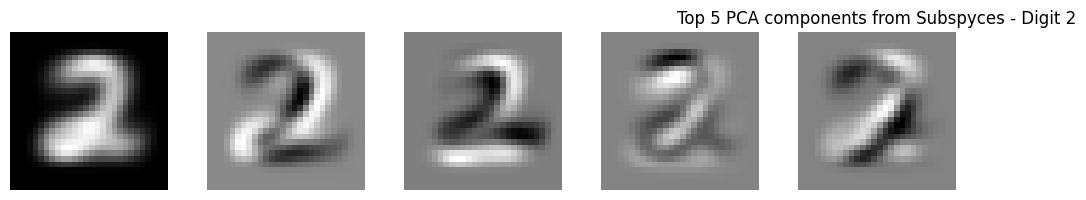

In [5]:
import torchvision.transforms as T
from subspyces.core import VectorSpace
from subspyces.generators import IdentityGenerator
from subspyces.transform import PCATransform

mnist_train = MNIST("~/Datasets", download=True, train=True,
                    transform=T.Compose([T.ToTensor(), torch.flatten]))

generator = IdentityGenerator()
train_vector_spaces = generator.generate(mnist_train, batch_size=512)
pca_transform = PCATransform(n_components=5)
pca_vector_subspaces = dict()

for vector_space in train_vector_spaces.values():
    pca_vector_subspace = pca_transform.transform(vector_space)
    pca_vector_subspaces[pca_vector_subspace.label] = pca_vector_subspace

subspace_1 = [vs.view(28, 28) for vs in pca_vector_subspaces[1]._data]
subspace_2 = [vs.view(28, 28) for vs in pca_vector_subspaces[2]._data]

show_matrix(subspace_1, "Top 5 PCA components from Subspyces - Digit 1")
show_matrix(subspace_2, "Top 5 PCA components from Subspyces - Digit 2")

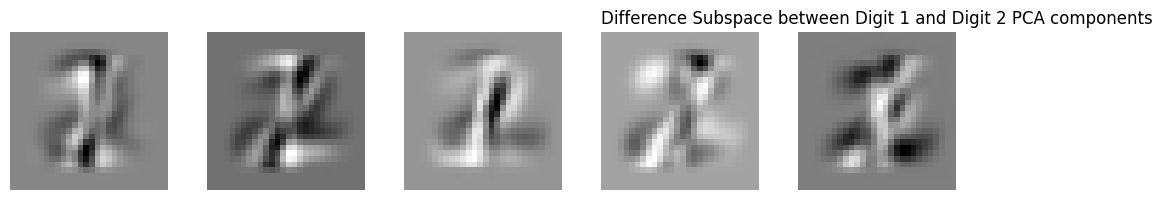

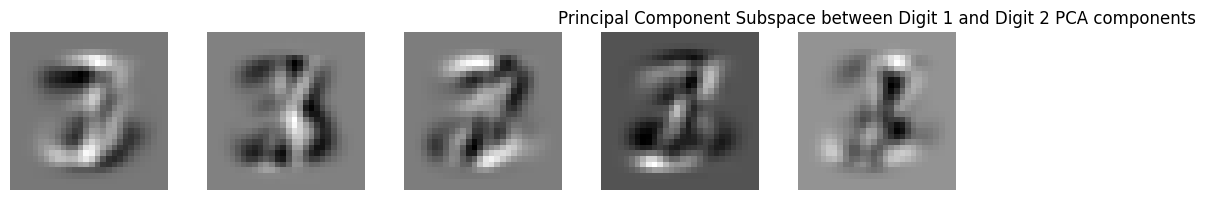

In [6]:
def compute_difference_pc_subspace(*subspaces: torch.Tensor) -> torch.Tensor:
    orthogonal_projections = []
    for s in subspaces:
        assert s.dim() == 2, "Input subspaces must be 2D tensors"
        orthogonal_projections.append(s @ s.mH)

    sum = torch.stack(orthogonal_projections).sum(dim=0)

    eigenvalues, eigenvectors = torch.linalg.eigh(sum)
    eigenvalues = torch.real(eigenvalues)
    eigenvectors = torch.real(eigenvectors)
    
    sorted_indices = torch.argsort(torch.abs(eigenvalues), descending=True)
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    first_less_than_1 = torch.where(eigenvalues < 1.0)[0][0]

    difference_subspace = eigenvectors[:, first_less_than_1:first_less_than_1 + subspaces[0].shape[1]]
    if first_less_than_1 > subspaces[0].shape[1]:
        principal_component_subspace = eigenvectors[:, :subspaces[0].shape[1]]
    else:
        principal_component_subspace = eigenvectors[:, :first_less_than_1]

    return difference_subspace, principal_component_subspace

diff, _ = compute_difference_pc_subspace(
    pca_vector_subspaces[1]._data.T,
    pca_vector_subspaces[2]._data.T,
)
_, principal = compute_difference_pc_subspace(
    pca_vector_subspaces[3]._data.T,
    diff,
)

show_matrix(
    [diff[:, i].view(28, 28) for i in range(n_components)],
    "Difference Subspace between Digit 1 and Digit 2 PCA components",
)
show_matrix(
    [principal[:, i].view(28, 28) for i in range(n_components)],
    "Principal Component Subspace between Digit 1 and Digit 2 PCA components",
)

In [7]:
from tqdm.auto import tqdm


population_size = 50
subspace_dim = (X.shape[0], n_components)
epochs = 100


# Initialize population and enforce orthonormality using QR decomposition
population = torch.randn(population_size, *subspace_dim, device=device)
population, _ = torch.linalg.qr(population)
print("Initialized population with shape", population.shape)

best_fitness_history = []
mean_fitness_history = []
for epoch in (pbar := tqdm(range(epochs), desc="Epochs")):
    # Evaluate objective function for each individual
    fitness = objective_function(X, population)

    for i in range(population_size):
        # pick three *distinct* indices not equal i
        idxs = [idx for idx in range(population_size) if idx != i]
        samples = torch.randperm(len(idxs))[:3]
        x1, x2, x3 = population[samples[0]], population[samples[1]], population[samples[2]]

        # Mutation
        diff, _ = compute_difference_pc_subspace(x2, x3)
        _, principal = compute_difference_pc_subspace(x1, diff)
        mutant = principal

        # Cross-over (binomial)
        cross_points = torch.rand(mutant.shape[1], device=device) < 0.5
        j_rand = torch.randint(0, mutant.shape[1], (1,), device=device)
        cross_points[j_rand] = True
        trial = torch.where(cross_points.unsqueeze(0), mutant, population[i])
        trial, _ = torch.linalg.qr(trial)

        # Selection
        f_trial = objective_function(X, trial)
        if f_trial > fitness[i]:
            population[i] = trial
            fitness[i] = f_trial

    # Record best and mean fitness
    best_idx = torch.argmax(fitness).item()
    best_fitness_history.append(fitness[best_idx].item())
    mean_fitness_history.append(torch.mean(fitness).item())
    pbar.set_postfix(best_fitness=fitness[best_idx], mean_fitness=mean_fitness_history[-1])

# Get the best individual from the final population
best_idx = torch.argmax(fitness)
Q2 = population[best_idx]

Initialized population with shape torch.Size([50, 784, 5])


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Objective function value: 10.882884


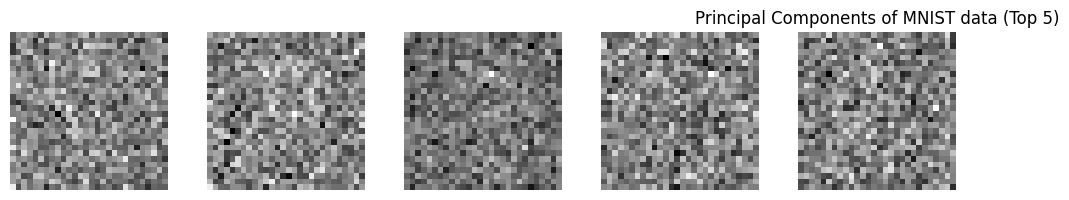

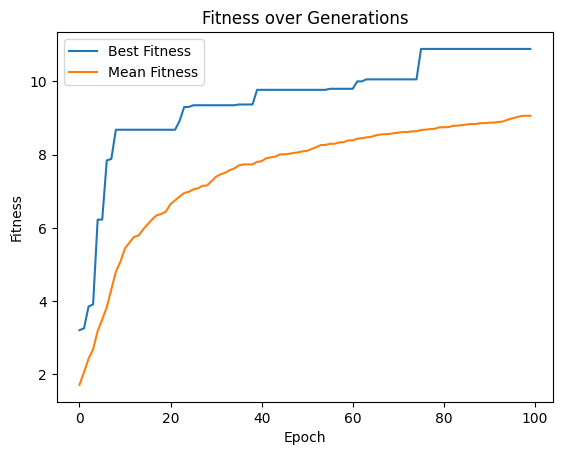

In [8]:
import matplotlib.pyplot as plt

o = objective_function(X, Q2)
print(f"Objective function value: {o.item():.6f}")

show_matrix(
    [Q2[:, i].view(28, 28) for i in range(n_components)],
    f"Principal Components of MNIST data (Top {n_components})",
)

plt.plot(best_fitness_history, label="Best Fitness")
plt.plot(mean_fitness_history, label="Mean Fitness")
plt.xlabel("Epoch")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.show()

# Very bad!